# НИРС
## Исследование применения моделей машинного обучения для прогнозирования качества вина по физико-химическим характеристикам
### РТ5-61Б Ильина Ксения 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

In [2]:
# Считываем данные
red_wine = pd.read_csv('winequality-red.csv', sep=';')
white_wine = pd.read_csv('winequality-white.csv', sep=';')

# Добавляем столбец типа вина
red_wine['type'] = 'red'
white_wine['type'] = 'white'

# Объединяем датасеты
data = pd.concat([red_wine, white_wine], axis=0).reset_index(drop=True)

# Создаем новые признаки
data['alcohol_to_sugar'] = data['alcohol'] / (data['residual sugar'] + 1e-6)
data['acid_balance'] = data['citric acid'] / (data['volatile acidity'] + 1e-6)
data['total_acidity'] = data['fixed acidity'] + data['volatile acidity'] + data['citric acid']

# Проверяем новые признаки
print(data[['alcohol_to_sugar', 'acid_balance', 'total_acidity']].describe())
# Кодируем категориальный признак 'type'
data = pd.get_dummies(data, columns=['type'], drop_first=True)  # создаст 'type_white' = 1, 'type_red' = 0
# Проверяем
print("Форма датасета:", data.shape)
data.head()

       alcohol_to_sugar  acid_balance  total_acidity
count       6497.000000   6497.000000    6497.000000
mean           3.935654      1.193659       7.873606
std            2.966427      0.735549       1.388024
min            0.177812      0.000000       4.130000
25%            1.230769      0.717947       7.020000
50%            3.531249      1.133330       7.600000
75%            5.882349      1.599994       8.380000
max           17.666637      8.299959      17.045000
Форма датасета: (6497, 16)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,alcohol_to_sugar,acid_balance,total_acidity,type_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4.947366,0.000000,8.10,False
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,3.769229,0.000000,8.68,False
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,4.260868,0.052632,8.60,False
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,5.157892,1.999993,12.04,False
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4.947366,0.000000,8.10,False


       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

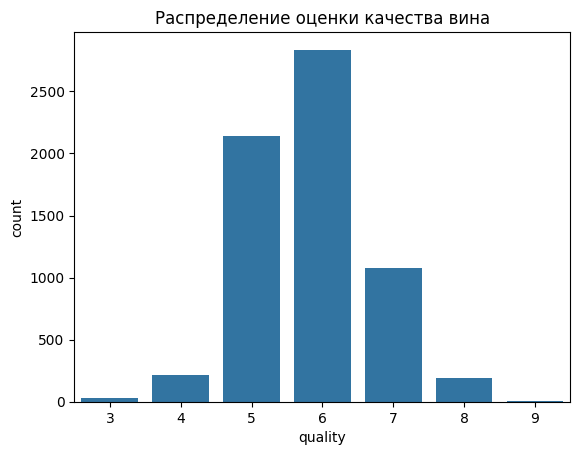

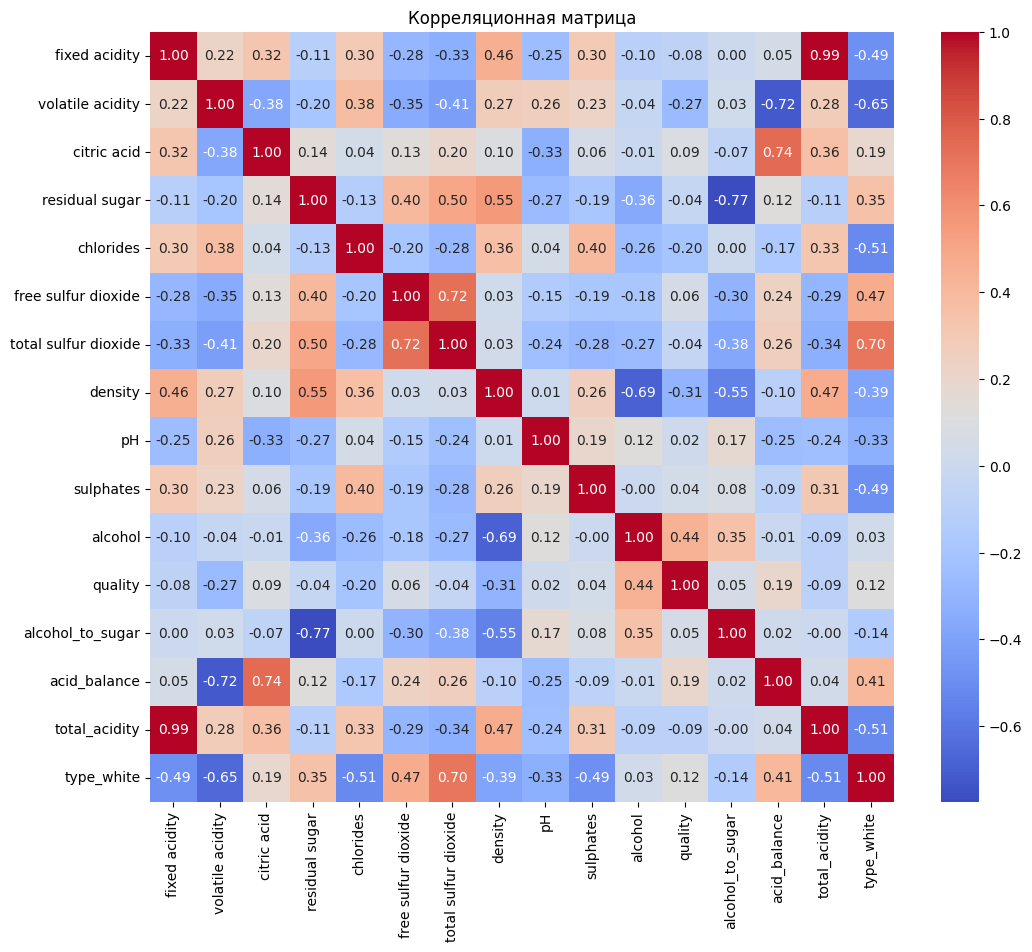

In [3]:
# Описательная статистика
print(data.describe())

# Распределение качества вина
sns.countplot(x='quality', data=data)
plt.title('Распределение оценки качества вина')
plt.show()

# Корреляционная матрица
corr_matrix = data.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

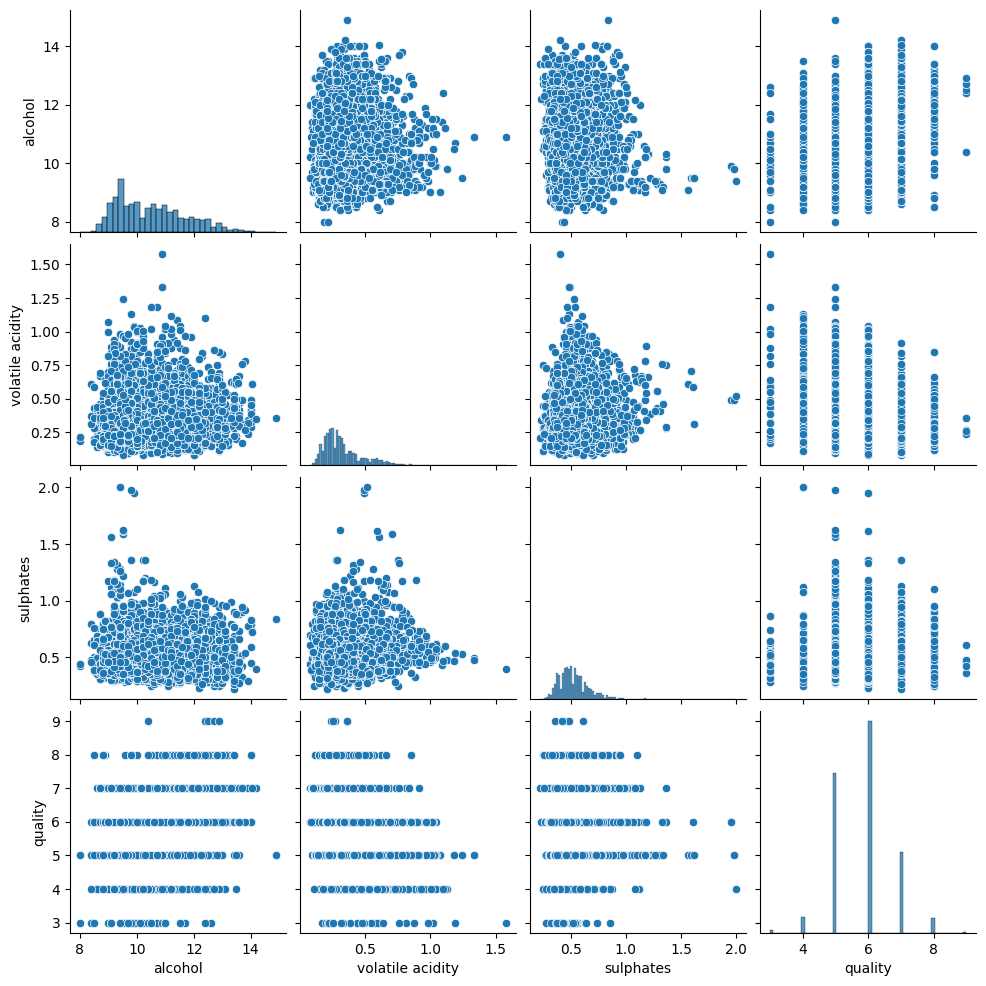

In [4]:
# Упрощенный pairplot для ключевых признаков
sns.pairplot(data[['alcohol', 'volatile acidity', 'sulphates', 'quality']])
plt.show()

In [5]:

# Проверка на пропуски
print("Пропуски:\n", data.isnull().sum())

# Разделение на признаки и целевую переменную
X = data.drop('quality', axis=1)
y = data['quality']

Пропуски:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
alcohol_to_sugar        0
acid_balance            0
total_acidity           0
type_white              0
dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Словарь моделей
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

# Вывод результатов
baseline_results_df = pd.DataFrame(results).T
baseline_results_df.sort_values(by="MAE")

,MAE,MSE,R2
Random Forest,0.437608,0.372752,0.495289
Decision Tree,0.504615,0.712308,0.035528
SVR,0.511569,0.457604,0.380399
Gradient Boosting,0.533472,0.461830,0.374678
Linear Regression,0.561619,0.536924,0.272999


In [8]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}
grid_rf = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,          # используем все ядра процессора
    verbose=0           # отключаем подробный вывод, чтобы не мешало
)

grid_rf.fit(X_train_scaled, y_train)

best_rf = grid_rf.best_estimator_
print("Лучшие параметры:", best_rf.get_params())

Лучшие параметры: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [9]:
param_grid_gb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring='neg_mean_squared_error')
grid_gb.fit(X_train_scaled, y_train)

best_gb = grid_gb.best_estimator_

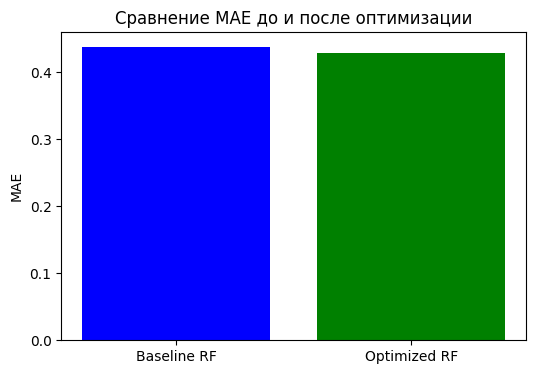

Baseline MAE: 0.4376076923076922
Optimized MAE: 0.4290923076923077


In [10]:
optimized_models = {
    "Optimized RF": best_rf,
    "Optimized GB": best_gb
}

results_optimized = {}

for name, model in optimized_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results_optimized[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred)
    }

# Вывод результатов
optimized_results_df = pd.DataFrame(results_optimized).T
optimized_results_df.sort_values(by="MAE")
baseline_mae = baseline_results_df.loc["Random Forest", "MAE"]
optimized_mae = optimized_results_df.loc["Optimized RF", "MAE"]

plt.figure(figsize=(6, 4))
plt.bar(['Baseline RF', 'Optimized RF'], [baseline_mae, optimized_mae], color=['blue', 'green'])
plt.ylabel('MAE')
plt.title('Сравнение MAE до и после оптимизации')
plt.show()
print("Baseline MAE:", baseline_results_df.loc["Random Forest", "MAE"])
print("Optimized MAE:", optimized_results_df.loc["Optimized RF", "MAE"])

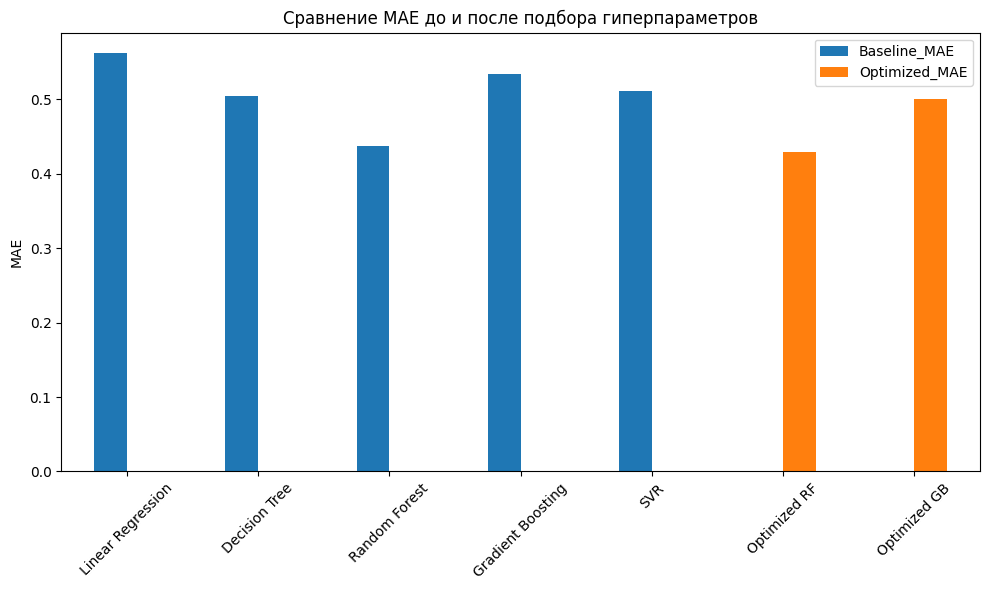

In [11]:
comparison_df = pd.concat([baseline_results_df, optimized_results_df], axis=1)
comparison_df.columns = ['Baseline_MAE', 'Baseline_MSE', 'Baseline_R2',
                         'Optimized_MAE', 'Optimized_MSE', 'Optimized_R2']
comparison_df[['Baseline_MAE', 'Optimized_MAE']].plot(kind='bar', figsize=(10, 6))
plt.title("Сравнение MAE до и после подбора гиперпараметров")
plt.ylabel("MAE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
!pip install shap


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


SHAP values shape: (1300, 15)


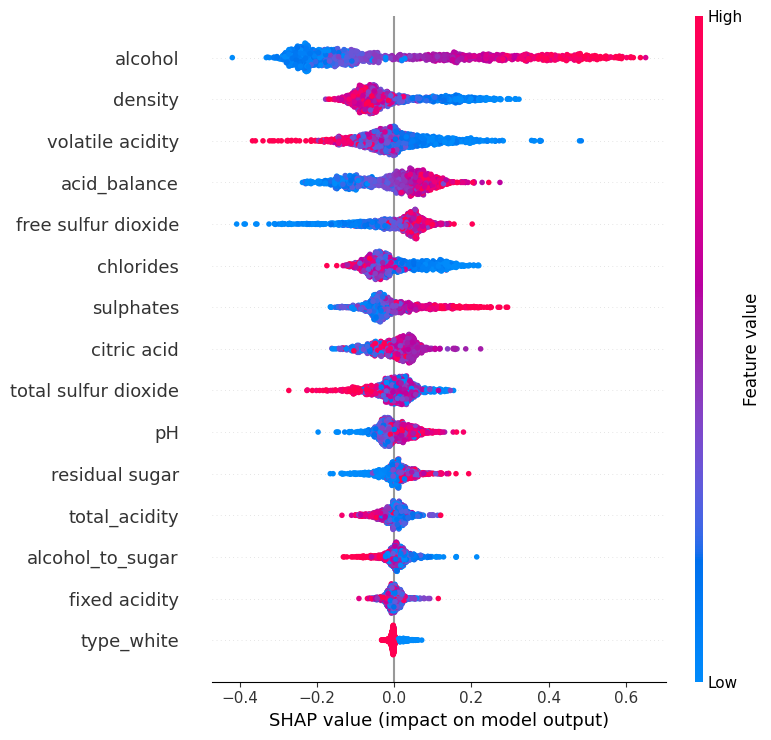

In [16]:
import shap
shap.initjs()  # <- Добавьте эту строку перед визуализациями
# Ваш код SHAP
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test_scaled)

# Проверка данных
print("SHAP values shape:", np.array(shap_values).shape)  # Должно быть (n_samples, n_features)

# Визуализация
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

# Анализ отдельных предсказаний
sample_idx = 0  # Можно изменить на любой индекс из тестовой выборки
shap.force_plot(explainer.expected_value, shap_values[sample_idx, :], 
                X_test_scaled[sample_idx, :], feature_names=X.columns)



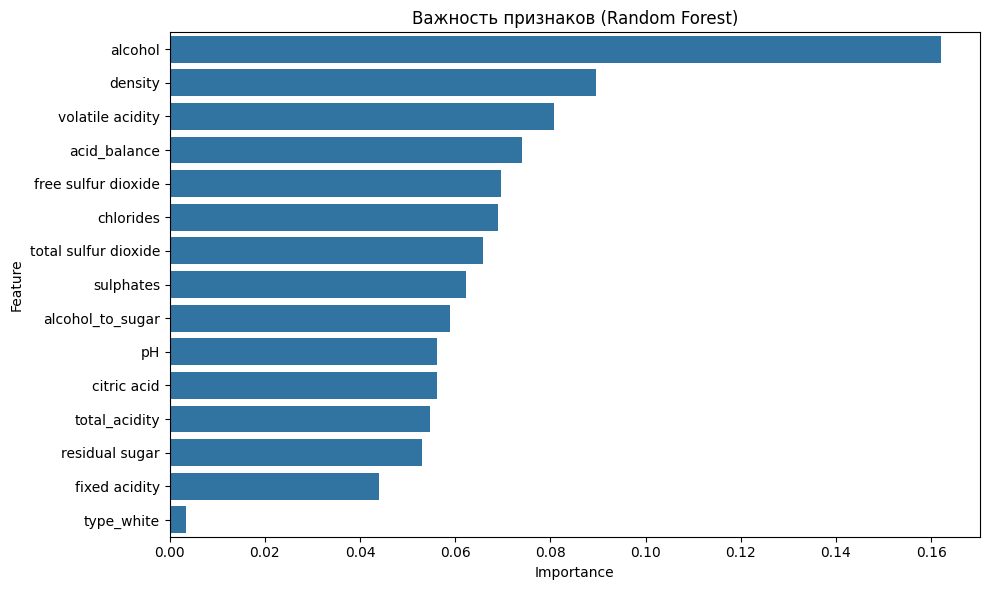

In [14]:
feature_importances = best_rf.feature_importances_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Важность признаков (Random Forest)')
plt.tight_layout()
plt.show()